# Wind Data From NOAA's Rapid Refresh
---

**NOAA**: National Oceanic and Atmospheric Administration

**RAP**: Rapid Refresh  
Information can be found at the following url:
https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/rapid-refresh-rap

Data can be retrieved using the NetCDF Subset Service (NCSS). Information on this protocol are available at: https://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html

The Rapid Refresh (RAP) numerical weather model is run by the National Centers for Environmental Prediction (NCEP), which is part of of the NOAA. Multiple data sources go into the generation of RAP model: commercial aircraft weather data, balloon data, radar data, surface observations, and satellite data. The model generates data down to a 13x13 squre kilometer resolution grid every hour. 

In [1]:
from powersimdata.input.grid import Grid
from prereise.gather.winddata.rap import rap, impute, helpers

import pandas as pd
from matplotlib import pyplot

## 1. Wind Farms in Network

In [2]:
grid = Grid(['Texas','Western'])
wind_farm = grid.plant.groupby('type').get_group('wind')

Reading bus.csv
Reading plant.csv
Reading gencost.csv
Reading branch.csv
Reading dcline.csv
Reading sub.csv
Reading bus2sub.csv
Reading zone.csv


In [3]:
wind_farm.head()

,bus_id,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin,...,type,interconnect,GenFuelCost,GenIOB,GenIOC,GenIOD,lat,lon,zone_id,zone_name
plant_id,,,,,,,,,,,,,,,,,,,,,
10397,2010691,59.72,21.07,21.07,-14.24,1.0061,98.92,1,98.9,16.6489,...,wind,Western,0.0,0.0,0.0,0,45.8131,-120.347,201,Washington
10400,2010699,79.42,-14.50,21.45,-14.50,1.0019,120.64,1,100.7,13.1500,...,wind,Western,0.0,0.0,0.0,0,47.1356,-120.687,201,Washington
10401,2010703,136.30,29.03,29.03,-19.63,1.0623,174.64,1,136.3,43.0626,...,wind,Western,0.0,0.0,0.0,0,45.8797,-120.807,201,Washington
10428,2010746,66.35,-12.96,19.17,-12.96,1.0205,98.26,1,90.0,19.9300,...,wind,Western,0.0,0.0,0.0,0,46.9547,-120.182,201,Washington
10442,2010768,212.51,56.83,56.83,-38.42,1.0299,301.55,1,266.8,122.1480,...,wind,Western,0.0,0.0,0.0,0,46.4211,-118.027,201,Washington


In [4]:
print("There are %d wind farms in the Western + Texas interconnection." % len(wind_farm))

There are 330 wind farms in the Western + Texas interconnection.


## 2. Downloading Data from NCEP's Server
Only few days are considered here. Note that some files on the server may be missing.

In [5]:
data, missing = rap.retrieve_data(wind_farm, start_date='2016-01-01', end_date='2016-01-10')

100%|██████████| 240/240 [07:15<00:00,  1.82s/it]


In [6]:
print("There are %d missing files." % len(missing))

There are 33 missing files.


In [7]:
data.head()

,plant_id,U,V,Pout,ts,ts_id
0,10397,-6.482498,-3.10574,38.257283,2016-01-01,1
1,10400,-5.482498,5.89426,48.482964,2016-01-01,1
2,10401,-6.982498,-2.48074,56.171348,2016-01-01,1
3,10428,-6.357498,-1.60574,28.169793,2016-01-01,1
4,10442,-2.732498,-3.98074,33.227313,2016-01-01,1


## 3. Plot Data
One wind farm is selected. The U and V components of the wind speed (in m/s) 80-m above ground along with the power output (in MW) are then plotted. One can see the missing data. Note that there are 242 files (hour equivalent) missing in 2016.

In [8]:
data_oneplant = data[data.plant_id == 10400]

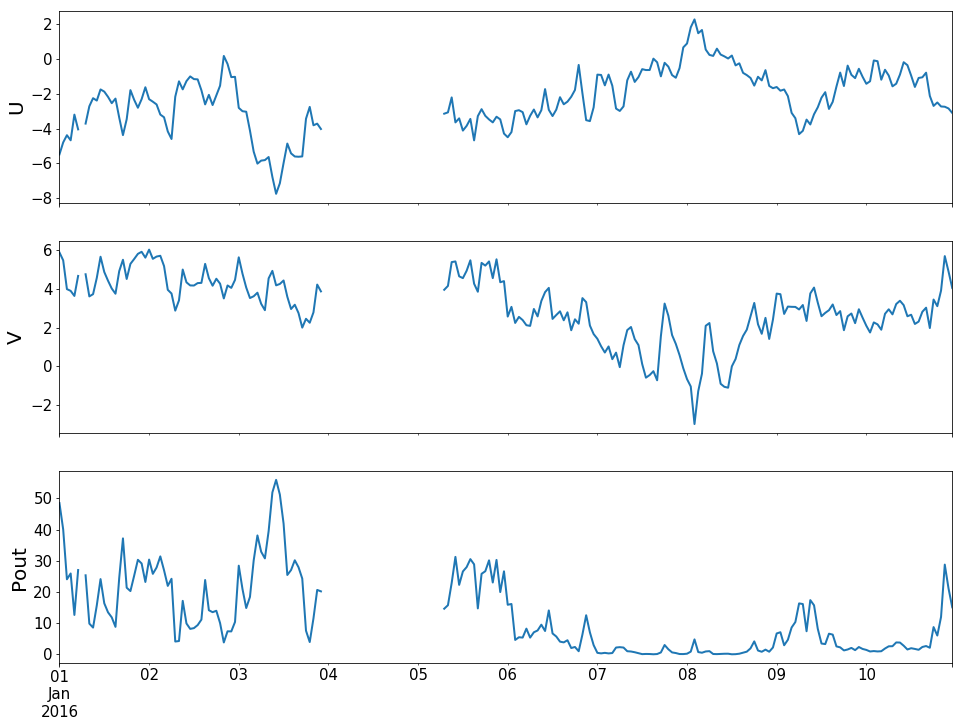

In [9]:
fig, ax = pyplot.subplots(nrows=3, ncols=1, sharex='col', figsize=(16,12))
for i, var in enumerate(['U','V','Pout']):
    data_oneplant.plot(x='ts', y=var, ax=ax[i], legend=False, fontsize=15, lw=2)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(var, fontsize=20)

pyplot.show()

## 4. Impute Missing Data
The missing data are imputed inplace using a simple procedure. The plot below shows the imputed data.

In [10]:
impute.gaussian(data, wind_farm, inplace=True)

100%|██████████| 10890/10890 [00:20<00:00, 521.47it/s]


In [11]:
data_impute_oneplant = data[data.plant_id == 10400]

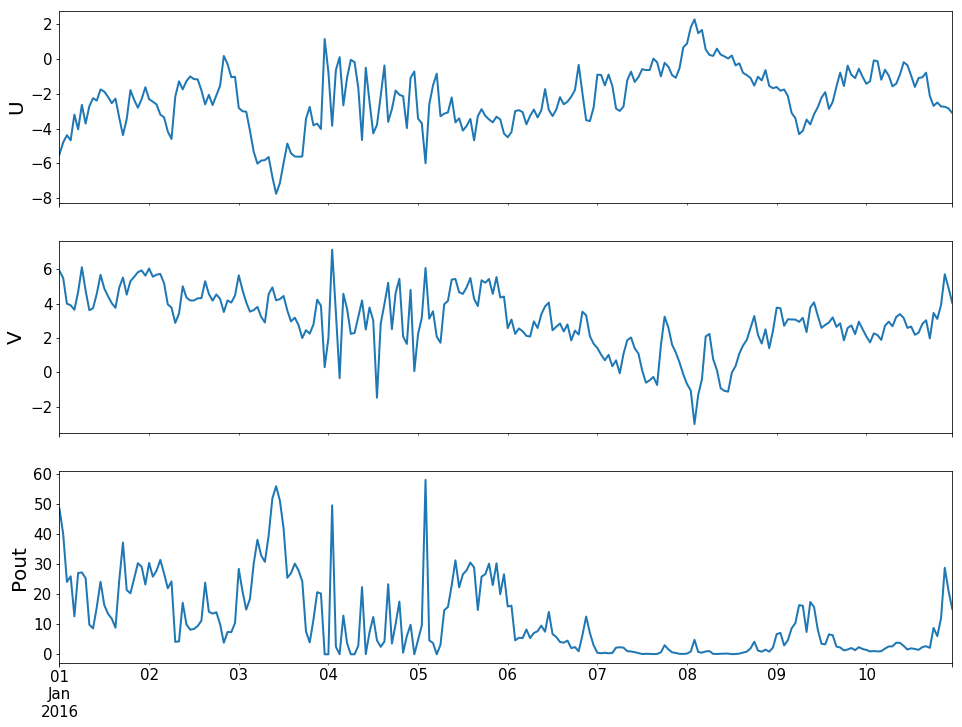

In [12]:
fig, ax = pyplot.subplots(nrows=3, ncols=1, sharex='col', figsize=(16,12))
for i, var in enumerate(['U','V','Pout']):
    data_impute_oneplant.plot(x='ts', y=var, ax=ax[i], legend=False, fontsize=15, lw=2)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(var, fontsize=20)

pyplot.show()

## 5. Format Data
Data are formated for REISE.

In [13]:
data_reise = helpers.to_reise(data)

In [14]:
data_reise.head()

,10397,10400,10401,10428,10442,10458,10463,10475,10522,10541,...,13042,13043,13054,13055,13056,13079,13080,13084,13085,13116
UTC,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,38.257283,48.482964,56.171348,28.169793,33.227313,4.236765,35.905879,48.157681,21.109980,24.780772,...,82.322913,83.515999,82.940027,37.849615,54.397074,27.089944,54.033918,73.846560,61.711329,102.639281
2016-01-01 01:00:00,45.785499,40.044639,60.350466,23.262101,18.689002,9.216575,42.059465,47.442281,20.539104,27.794477,...,86.500079,87.753704,87.148506,39.770151,67.810708,29.983488,73.278058,110.583295,64.842638,111.709352
2016-01-01 02:00:00,43.052244,24.071764,56.594751,25.396245,22.492057,15.166913,41.895027,32.088467,18.911527,25.885419,...,99.238930,100.677175,99.982850,45.627094,63.437696,31.186428,66.774718,106.707569,74.392001,111.341453
2016-01-01 03:00:00,49.119785,25.939710,69.368825,33.794145,8.308223,14.282208,48.419946,51.581705,23.980621,27.975273,...,91.792648,93.122977,92.480749,42.203516,59.286650,26.997862,62.399327,107.082886,68.810081,102.025856
2016-01-01 04:00:00,50.443662,12.651200,75.110869,32.838747,3.808979,9.727841,51.339725,53.660753,25.573866,29.041188,...,79.598559,80.752161,80.195250,36.597039,70.886676,25.496325,81.118187,111.592527,59.669085,101.547720
